根據閱讀完EDA文章整理出的 check_list:
你想要用資料解決甚麼問題?  
餐廳老闆經營對成本分析,斷貨風險,成本考量之類的問題  
你擁有甚麼樣的資料?你將如何處理不同的資料特徵?  
資料來源:公有零售市場每日蔬果價格填報(GOLD綜整1100122) 

在建模型前先把description看清楚   
資料描述(摘於台中市政府資料開放平台):(Subject-matter expert)  
1.臺中市政府公有零售市場名稱、日期、蔬果品項、平均價格(元/斤)。   
2.每日由臺中市政府經發局13大公有零售市場持續更新價格內容。    
3.蔬果品項： 絲瓜/花胡瓜/結球白菜/蘿蔔/胡蘿蔔/青蔥/胡瓜/青江白菜/空心菜/甘藍/香蕉/番石榴(珍珠)/鳳梨(開英)/荔枝(黑葉)/火龍果(紅肉)/芒果(愛文)/木瓜/文旦/新世紀梨/檸檬/鳳梨(四號)/火龍果(白肉)/新興梨/橫山梨/牛心柿/甜柿/紅柿(軟柿)/桶柑/椪柑/海梨柑   
4.無該蔬果品項價格時,內容填"0"。  

資料特徵 以下表格整理  
資料哪裡有缺失或不完整?要怎麼處理才不會影響分析結果?  
觀察資料後檢視datatype,先將數值資料轉為int,或float方便之後運算 
發現有異常值經觀察後假設為人為手key錯誤,直接修正  
將資料中時間欄位轉為datetime格式    
資料中有outliers要怎麼處理?及缺失值     
在處理資料青蔥時發現有個值異常價格,50000000000000,這裡填寫其他12座市場的平均價  
(ps:是有其他更好的處理方式)  


資料名稱 | 統計項目
--- | ---:
訪問天數|308|
品項|61|
市場數|13|

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py 
import plotly.graph_objs as go 
import plotly.tools as tls
import plotly.figure_factory as ff
import pandas as pd 
import scipy.stats as stats
import time
import datetime
from numpy import *

In [3]:
df = pd.read_csv('https://datacenter.taichung.gov.tw/swagger/OpenData/7196c54b-966b-48c8-8c3e-5124ac8070d1')
len(set(df['訪價日期'])) #資料調查時間總時長為308天
len(set(df['市場名稱'])) #總共訪問了 13 座菜市場
#df.info()
a = [i for i in df.columns]
len(a) #蔬菜水果總類有61項 #其中有幾項datatype為 object想辦法轉為數值 #鳳梨_開英/文旦

set(df['鳳梨_開英'])
df[df.鳳梨_開英 =="0-"] 
#df.loc[df['鳳梨_開英'] =="0-"] = 0  #這樣整行資料都會被改為0
df.iloc[1855,14] = 0 #用iloc直接修改某一元素值 #資料中出現0- 判斷應為手key錯誤

df['鳳梨_開英'] = df['鳳梨_開英'].astype(int)
df['鳳梨_開英']
set(df['文旦'])#
#df[df['市場名稱'].str.contains('中義市場')]
a = df.loc[df.市場名稱.str.contains('中義市場',na=False)]['文旦'] #ValueError: cannot index with vector containing NA / NaN values
[i for i in a] #觀察數據後判斷39+應該是人為key錯
df[df.文旦 == "39+"] 
df.iloc[1642,19] = 39
df['文旦'] = df['文旦'].astype(int)
#df.info()

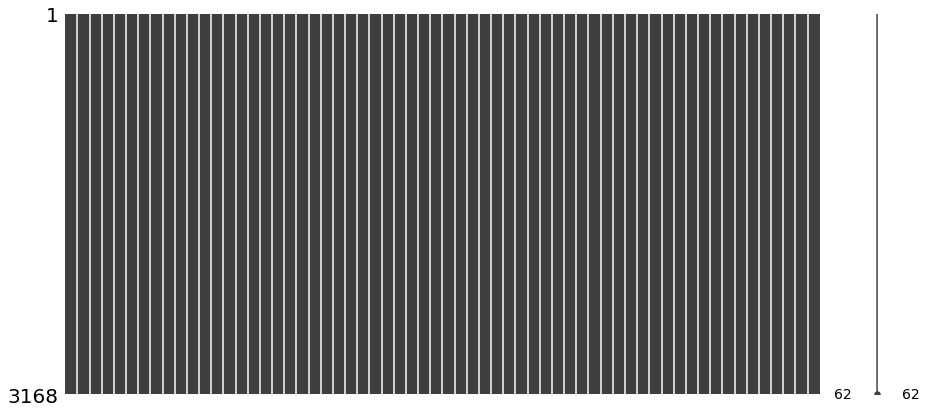

In [37]:
import missingno as msno
msno.matrix(df, figsize = (15,7)) #應該是沒有遺失值@@ 

In [8]:
#df['訪價日期_'] = pd.to_datetime(df['訪價日期'], format = "%d/%m/%Y",) #將資料時間的部分設為index並變成時間格式:datetime64
#df.set_index("訪價日期_",inplace = True)
#df.drop(columns=["訪價日期"],inplace=True)
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3168 entries, 2020-03-21 to 2021-01-22
Data columns (total 62 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   市場名稱     3168 non-null   object 
 1   絲瓜       3168 non-null   float64
 2   花胡瓜      3168 non-null   int64  
 3   結球白菜     3168 non-null   int64  
 4   蘿蔔       3168 non-null   int64  
 5   胡蘿蔔      3168 non-null   int64  
 6   青蔥       3168 non-null   float64
 7   胡瓜       3168 non-null   int64  
 8   青江白菜     3168 non-null   int64  
 9   空心菜      3168 non-null   int64  
 10  甘藍       3168 non-null   int64  
 11  香蕉       3168 non-null   int64  
 12  番石榴_珍珠   3168 non-null   int64  
 13  鳳梨_開英    3168 non-null   int32  
 14  荔枝_黑葉    3168 non-null   int64  
 15  火龍果_紅肉   3168 non-null   int64  
 16  芒果_愛文    3168 non-null   int64  
 17  木瓜       3168 non-null   int64  
 18  文旦       3168 non-null   int32  
 19  新世紀梨     3168 non-null   int64  
 20  檸檬       3168 non-null   int64  
 

DatetimeIndex(['2020-03-21', '2020-03-22', '2020-03-22', '2020-03-22',
               '2020-03-22', '2020-03-22', '2020-03-22', '2020-03-22',
               '2020-03-22', '2020-03-22',
               ...
               '2021-01-21', '2021-01-21', '2021-01-21', '2021-01-21',
               '2021-01-21', '2021-01-21', '2021-01-21', '2021-01-22',
               '2021-01-22', '2021-01-22'],
              dtype='datetime64[ns]', name='訪價日期_', length=3168, freq=None)

In [ ]:
outlier = df.青蔥['2020-06-20'] #處理outlier
z = df.青蔥
s = [i for i in z]
s.remove(50000000000000)
s = mean(s)
outlier.iloc[6] = s

In [ ]:
df.describe()
df.describe().loc[['min','max']]        #從最小值可以發現,只要某市場某日某個品項不賣就會變成0,因此可以思考怎麼求各個品項的最小值
                        
a = df.describe().loc['min']         #反面來說如果min有不為0的數,表示它應該蠻好賣,台中市全年大部分時間都能在某個市場買到  
a[a > 0]                   #看起來是 胡蘿蔔 胡瓜 青江白菜 
                        #接下來寫出一個可以測出各品項min的function
def cheap(x):                 #這個function可以將便宜價取出
 便宜價 = [a for a in df[x]]       #蠻想把每個品項的真正最便宜價格塞進統計資料裡
 便宜價 = set(便宜價)             #ps:其他統計數據也會需要轉換,這裡只先求最小值
 try:
       便宜價.remove(0)
       min(便宜價)
 except:
       min(便宜價)
 return min(便宜價)

cheap("絲瓜")               


0.35

In [ ]:
a =[]
for i in df.columns:
    if i != "市場名稱":
       便宜價 = [a for a in df[i]]
       便宜價 = set(便宜價)
       try:
        便宜價.remove(0)
        a.append(min(便宜價))
       except:
        a.append(min(便宜價))  
#print(a)
品項 = df.columns.tolist()
品項.remove('市場名稱')  
keys = 品項
values = a
real_cheap = dict(zip(keys, values))
#print(real_cheap)
cheap = pd.DataFrame(real_cheap,index=["cheapest"])  #轉為dataframe
df.describe()
score_df = df.describe().append(cheap)
#print(a)
score_df.round(2) #其他統計數值也需要調整,

,絲瓜,花胡瓜,結球白菜,蘿蔔,胡蘿蔔,青蔥,胡瓜,青江白菜,空心菜,甘藍,香蕉,番石榴_珍珠,鳳梨_開英,荔枝_黑葉,火龍果_紅肉,芒果_愛文,木瓜,文旦,新世紀梨,檸檬,鳳梨_四號,火龍果_白肉,新興梨,橫山梨,牛心柿,甜柿,紅柿_軟柿,桶柑,椪柑,海梨柑,鳯梨_金鑽,柳橙,蓮霧,棗子,茂谷柑,芒果,大西瓜,小番茄_玉女,小番茄_聖女,花椰菜,洋蔥,大蒜,吳郭魚,虱目魚,金目鱸,龍虎班,午仔魚,白蝦,文蛤,里肌肉,後腿肉,五花肉,牛腱_冷凍牛肉,腿肉_冷凍牛肉,腩肉_冷凍牛肉,雞蛋,鴨蛋,肉雞,土雞,仿雞,鴨_土番鴨
count,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00,3168.00
mean,33.05,41.15,32.89,27.44,26.19,59.61,34.30,36.17,26.34,33.91,18.63,26.63,4.82,5.37,29.91,25.12,36.79,7.57,8.16,28.65,7.65,18.41,24.71,3.29,0.85,30.26,4.63,4.39,13.17,0.68,14.36,8.80,53.68,14.85,11.34,10.22,7.67,61.62,29.25,43.12,27.46,104.13,42.87,78.39,74.98,35.45,126.11,182.28,74.50,128.82,102.23,128.04,131.50,100.30,117.41,30.67,43.87,55.91,112.00,94.06,88.27
std,13.50,18.02,11.85,11.41,6.83,25.78,142.49,16.87,18.12,46.71,12.64,19.29,10.08,18.27,28.80,87.50,23.47,18.83,27.65,22.26,46.48,27.76,36.43,13.19,5.42,43.81,12.80,14.00,20.98,4.89,14.61,13.09,233.38,30.41,24.50,24.27,12.64,66.48,40.08,22.87,7.93,59.16,38.56,167.51,62.23,68.80,109.96,118.34,47.34,44.13,214.63,38.96,97.76,101.89,125.02,13.11,16.71,51.62,46.52,56.66,62.62
min,0.00,0.00,0.00,0.00,15.00,0.00,2.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,25.00,30.00,25.00,20.00,22.00,45.00,25.00,25.00,20.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.00,25.00,80.00,4.00,8.00,0.00,0.00,15.00,15.00,9.00,115.00,90.00,120.00,0.00,0.00,0.00,31.00,39.00,0.00,100.00,85.00,72.00
50%,30.00,45.00,35.00,25.00,25.00,50.00,30.00,30.00,30.00,35.00,20.00,29.00,0.00,0.00,35.00,0.00,35.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,20.00,0.00,0.00,0.00,0.00,40.00,0.00,40.00,30.00,90.00,55.00,90.00,96.00,0.00,160.00,220.00,96.00,130.00,110.00,130.00,180.00,40.00,170.00,33.00,46.00,80.00,120.00,110.00,100.00
75%,40.00,55.00,40.00,32.00,30.00,80.00,40.00,40.00,40.00,40.00,30.00,39.00,0.00,0.00,50.00,55.00,50.00,0.00,0.00,45.00,20.00,40.00,65.00,0.00,0.00,60.00,0.00,0.00,35.00,0.00,25.00,20.00,85.00,0.00,0.00,0.00,20.00,120.00,59.00,60.00,30.00,130.00,70.00,100.00,120.00,10.00,208.00,280.00,120.00,140.00,120.00,140.00,200.00,200.00,240.00,36.00,56.00,90.00,135.00,120.00,110.00
max,455.00,100.00,400.00,322.00,258.00,150.00,8040.00,410.00,500.00,2515.00,50.00,60.00,68.00,150.00,120.00,4539.00,410.00,80.00,900.00,80.00,2539.00,350.00,702.00,75.00,75.00,150.00,330.00,80.00,85.00,45.00,258.00,50.00,10000.00,130.00,85.00,550.00,233.00,550.00,130.00,100.00,100.00,1204.00,800.00,9000.00,240.00,1010.00,1660.00,350.00,130.00,1410.00,12002.00,1265.00,1580.00,300.00,2600.00,385.00,65.00,900.00,200.00,1200.00,340.00
cheapest,0.35,15.00,10.00,2.00,15.00,20.00,2.00,3.00,2.00,15.00,2.00,15.00,1.00,3.00,5.00,1.00,20.00,25.00,9.00,15.00,1.00,25.00,7.00,2.00,2.00,50.00,2.00,30.00,25.00,2.00,17.00,15.00,15.00,5.00,5.00,5.00,2.00,10.00,20.00,5.00,0.35,10.00,4.00,2.00,4.00,1.00,4.00,8.00,1.00,4.00,9.00,10.00,100.00,80.00,20.00,3.00,5.00,10.00,13.00,70.00,38.00


[20, 20, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 49, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 54, 54, 54, 54, 54, 53, 54, 55, 56, 56, 56, 56, 56, 56, 56, 56, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 54, 54, 55, 55, 55, 55, 57, 56, 56, 56, 56, 56, 56, 56, 56, 55, 55, 55, 55, 55, 55, 55, 55, 55, 54, 53, 54, 54, 54, 54, 54, 54, 54, 54, 52, 52, 52, 51, 52, 52, 51, 52, 52, 52, 51, 51, 50, 51, 51, 49, 50, 50, 50, 50, 50, 50, 50,

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcd002d9eb8>, None)

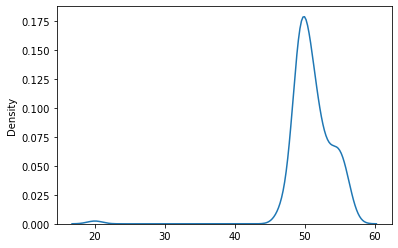

In [ ]:
#向哪個市場進貨品項最充足
(df[df.市場名稱.str.contains("中義")] != 0).sum(axis=1)-1 #該市場當天賣多少商品,-1是有一個columns是市場名稱
市場 = list(set(df['市場名稱']))  #考慮將市場名稱做成list,包裝成def

def 市場品項分布(x):
 for i  in x:  
   market_count =  [item for item in (df[df.市場名稱.str.contains(i)]!= 0).sum(axis=1)-1]

   return  sns.kdeplot(market_count),print(market_count)    #印出當天賣多少項目和全年分佈

市場品項分布("建國")  #聽說台中最大的市場是建國市場,那它每天應該賣最多品項

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 10.,  0.,  1.,  0., 74., 63.,  0., 48., 28.,
         0., 19.,  0., 17., 27.,  0., 16.,  1.]),
 array([20.        , 20.61666667, 21.23333333, 21.85      , 22.46666667,
        23.08333333, 23.7       , 24.31666667, 24.93333333, 25.55      ,
        26.16666667, 26.78333333, 27.4       , 28.01666667, 28.63333333,
        29.25      , 29.86666667, 30.48333333, 31.1       , 31.71666667,
        32.33333333, 32.95      , 33.56666667, 34.18333333, 34.8       ,
        35.41666667, 36.03333333, 36.65      , 37.26666667, 37.88333333,
        38.5       , 39.11666667, 39.73333333, 40.35      , 40.96666667,
        41.58333333, 42.2       , 42.81666667, 43.43333333, 44.05      ,
        44.66666667, 45.28333333, 45.9       , 46.51666667, 47.13333333,
 

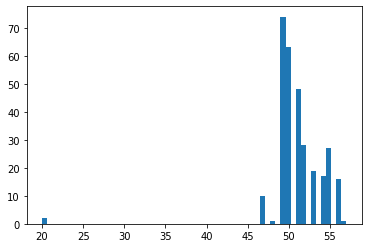

In [ ]:
def hist(x,z):   #直方圖
    for i  in x:  
         market_count =  [item for item in (df[df.市場名稱.str.contains(i)]!= 0).sum(axis=1)-1]
    return plt.hist(market_count,bins=z)

hist('建國',60)        #一年中大部分時間賣將近50左右品項